In [1]:
import numpy as np
import os, shutil
import PIL as pil
import matplotlib.pyplot as plt
from scipy.stats import norm

import tensorflow as tf

In [2]:
batch_size = 100
original_dim = 7500
latent_dim = 16
intermediate_dim = 512
epochs = 75
epsilon_std = 1.0

In [3]:
class NameSpacer:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)


class Architecture:
    def __init__(self, batch_size=None, original_dim=None, latent_dim=2,
                 intermediate_dim=256, name="architecture"):
        self.name = name
        self.batch_size = batch_size
        self.original_dim = original_dim
        self.latent_dim = latent_dim
        self.intermediate_dim = intermediate_dim
        self.optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
        self.define_computation_graph()

        # Aliases
        self.ph = self.placeholders
        self.op = self.optimizers
        self.summ = self.summaries

    def define_computation_graph(self):
        # Reset graph
        tf.reset_default_graph()
        self.placeholders = NameSpacer(**self.define_placeholders())
        self.core_model = NameSpacer(**self.define_core_model())
        self.losses = NameSpacer(**self.define_losses())
        self.optimizers = NameSpacer(**self.define_optimizers())
        self.summaries = NameSpacer(**self.define_summaries())

    def define_placeholders(self):
        with tf.variable_scope("Placeholders"):
            loss_dev = tf.placeholder(dtype=tf.float32, shape=(None), 
                                      name="loss_dev")
            x = tf.placeholder(dtype=tf.float32, shape=(self.batch_size, self.original_dim),
                                                       name="input")
            z = tf.placeholder(dtype=tf.float32, shape=(None, self.latent_dim),
                                                       name="latent_vactor")
            

            return {"loss_dev": loss_dev,
                   "x": x,
                   "z": z}
    
    def define_core_model(self):
        with tf.variable_scope("Core_Model"):
                        
            encode_x, encoded_means, encoded_stds = self.encode(self.placeholders.x)
            vae = self.decode(encode_x)
            
            decode_z = self.decode(self.placeholders.z, reuse=True)
            
            return {"output": vae,
                   "output_z": decode_z,
                    "z_means":encoded_means,
                    "z_log_stds": encoded_stds,
                    "encoded_x":encode_x
                   }

    def define_losses(self):
        with tf.variable_scope("Losses"):
            mse = tf.reduce_mean(tf.square(self.core_model.output-self.placeholders.x), axis=1)
            
            recon_loss = tf.reduce_mean(mse)
            kl_loss = -0.5 * tf.reduce_sum(
                1 + self.core_model.z_log_stds - tf.square(self.core_model.z_means) - 
                tf.square(tf.exp(self.core_model.z_log_stds)), axis=1)
            kl_loss = tf.reduce_mean(kl_loss)

            total_loss = tf.reduce_mean(recon_loss*7500 + kl_loss)
            
            #total_loss = tf.reduce_mean(mse + kl_loss)/1
            return {"loss": recon_loss,
                   "kl_loss": kl_loss,
                   "total_loss": total_loss}

    def define_optimizers(self):
        with tf.variable_scope("Optimization"):
            op = self.optimizer.minimize(self.losses.total_loss)
            return {"op": op}

    def define_summaries(self):
        with tf.variable_scope("Summaries"):
            train_final_scalar_probes = {"loss": tf.squeeze(self.losses.loss),
                                        "kl_loss":tf.squeeze(self.losses.kl_loss),
                                        "total_loss":tf.squeeze(self.losses.total_loss)}
            final_performance_scalar = [tf.summary.scalar(k, tf.reduce_mean(v), family=self.name)
                                        for k, v in train_final_scalar_probes.items()]
            dev_scalar_probes = {"loss_dev": self.placeholders.loss_dev}
            dev_performance_scalar = [tf.summary.scalar(k, v, family=self.name) for k, v in dev_scalar_probes.items()]
            dev_performance_scalar = tf.summary.merge(dev_performance_scalar)
            return {"scalar_train_performance": tf.summary.merge(final_performance_scalar),
                    "scalar_dev_performance": dev_performance_scalar}
    def encode(self, x):
        with tf.variable_scope("Encoder"):
            dense_enc_1 = tf.layers.dense(x, self.intermediate_dim, activation=tf.nn.relu ,
                                          name="dense_enc_1")
            dense_enc_2 = tf.layers.dense(dense_enc_1, self.intermediate_dim, activation=tf.nn.relu ,
                                          name="dense_enc_2")
            z_mean = tf.layers.dense(dense_enc_2, self.latent_dim, activation=None,
                                     name="dense_mean")
            z_log_sd = tf.layers.dense(dense_enc_2, self.latent_dim, activation=None,
                                       name="dense_sd")
            samples = tf.random_normal(tf.shape(z_mean),0,1,dtype=tf.float32)  
            sampled_z = z_mean + (tf.exp(z_log_sd) * samples)
            
            return sampled_z, z_mean, z_log_sd
        
    def decode(self, dec_input, reuse=False):
        with tf.variable_scope("Decoder", reuse=reuse):
            dense_dec_1 = tf.layers.dense(dec_input, self.intermediate_dim, activation=tf.nn.relu,
                                          name="dense_dec_1")
            dense_dec_2 = tf.layers.dense(dense_dec_1, self.intermediate_dim, activation=tf.nn.relu,
                                          name="dense_dec_2")
            decoder_mean = tf.layers.dense(dense_dec_2, self.original_dim, activation=tf.nn.sigmoid,
                                           name="dense_dec_mean")
            return decoder_mean
            


In [4]:
net = Architecture(batch_size=100, intermediate_dim=intermediate_dim, latent_dim=latent_dim, original_dim=original_dim)

In [5]:
sess = tf.Session()

In [6]:
sess.run(tf.global_variables_initializer())

ResourceExhaustedError: OOM when allocating tensor of shape [512,7500] and type float
	 [[Node: Optimization/Core_Model/Decoder/dense_dec_mean/kernel/Adam/Initializer/zeros = Const[_class=["loc:@Core_Model/Decoder/dense_dec_mean/kernel"], dtype=DT_FLOAT, value=Tensor<type: float shape: [512,7500] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'Optimization/Core_Model/Decoder/dense_dec_mean/kernel/Adam/Initializer/zeros', defined at:
  File "/home/user/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/user/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/user/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/user/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/user/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/user/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/user/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/user/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/user/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/user/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/user/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/user/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/user/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/user/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/user/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/user/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/user/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/user/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/user/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-4-0819e3d66102>", line 1, in <module>
    net = Architecture(batch_size=100, intermediate_dim=intermediate_dim, latent_dim=latent_dim, original_dim=original_dim)
  File "<ipython-input-3-17ede7ba8ab6>", line 15, in __init__
    self.define_computation_graph()
  File "<ipython-input-3-17ede7ba8ab6>", line 28, in define_computation_graph
    self.optimizers = NameSpacer(**self.define_optimizers())
  File "<ipython-input-3-17ede7ba8ab6>", line 79, in define_optimizers
    op = self.optimizer.minimize(self.losses.total_loss)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 325, in minimize
    name=name)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 446, in apply_gradients
    self._create_slots([_get_variable_for(v) for v in var_list])
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/training/adam.py", line 132, in _create_slots
    self._zeros_slot(v, "m", self._name)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/training/optimizer.py", line 766, in _zeros_slot
    named_slots[_var_key(var)] = slot_creator.create_zeros_slot(var, op_name)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 174, in create_zeros_slot
    colocate_with_primary=colocate_with_primary)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 146, in create_slot_with_initializer
    dtype)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/training/slot_creator.py", line 66, in _create_slot_var
    validate_shape=validate_shape)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 1065, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 962, in get_variable
    use_resource=use_resource, custom_getter=custom_getter)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 367, in get_variable
    validate_shape=validate_shape, use_resource=use_resource)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 352, in _true_getter
    use_resource=use_resource)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 725, in _get_single_variable
    validate_shape=validate_shape)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 199, in __init__
    expected_shape=expected_shape)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/ops/variables.py", line 277, in _init_from_args
    initial_value(), name="initial_value", dtype=dtype)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/ops/variable_scope.py", line 701, in <lambda>
    shape.as_list(), dtype=dtype, partition_info=partition_info)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py", line 93, in __call__
    return array_ops.zeros(shape, dtype)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/ops/array_ops.py", line 1401, in zeros
    output = constant(zero, shape=shape, dtype=dtype, name=name)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/constant_op.py", line 106, in constant
    attrs={"value": tensor_value, "dtype": dtype_value}, name=name).outputs[0]
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/user/.local/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [512,7500] and type float
	 [[Node: Optimization/Core_Model/Decoder/dense_dec_mean/kernel/Adam/Initializer/zeros = Const[_class=["loc:@Core_Model/Decoder/dense_dec_mean/kernel"], dtype=DT_FLOAT, value=Tensor<type: float shape: [512,7500] values: [0 0 0]...>, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [ ]:
def get_summary_writer(session, logs_path, project_id, version_id, remove_if_exists=True):
    """
    For Tensorboard reporting
    :param session: opened tensorflow session (tf.Session)
    :param logs_path: path where tensorboard is looking for logs (str)
    :param project_id: name of the project for reporting purposes (str)
    :param version_id: name of the version for reporting purposes (str)
    :param remove_if_exists: if True removes the log in case it exists (bool)
    :return summary_writer: the tensorboard writer
    """
    path = os.path.join(logs_path, "{}_{}".format(project_id, version_id))
    if os.path.exists(path) and remove_if_exists:
        shutil.rmtree(path)
    summary_writer = tf.summary.FileWriter(path, graph_def=session.graph_def)
    return summary_writer

In [ ]:
sw = get_summary_writer(sess, "/home/user/tensorflow_logs/", "VAE_tf", "LFW_naive")

In [ ]:
path_lfw = "/home/user/lfw/hola"
images_path = os.listdir(path_lfw)

data_ = [np.array(pil.Image.open(os.path.join(path_lfw, x)).resize((50, 50))) for x in images_path]

In [ ]:
np.random.seed(1616)

In [ ]:
np.random.shuffle(data_)

In [ ]:
x_train = data_[:13000]
x_test = data_[13000:]

In [ ]:
x_train = [(i.astype('float32') / 255) for i in x_train]
x_test = [(i.astype('float32') / 255) for i in x_test]

In [ ]:
x_train = [i.reshape((np.prod(x_train[0].shape[0:]))) for i in x_train]
x_test = [i.reshape((np.prod(x_train[0].shape[0:]))) for i in x_test]

In [ ]:
def batching(list_of_iterables, n=1, infinite=False, return_incomplete_batches=False):
    list_of_iterables = [list_of_iterables] if type(list_of_iterables) is not list else list_of_iterables
    assert(len({len(it) for it in list_of_iterables}) == 1)
    n_elements = len(list_of_iterables[0])
    while 1:
        for ndx in range(0, n_elements, n):
            if not return_incomplete_batches:
                if (ndx+n) > n_elements:
                    break
            yield [iterable[ndx:min(ndx + n, n_elements)] for iterable in list_of_iterables]

        if not infinite:
            break

In [ ]:
c=0

In [ ]:

for e in range(epochs):
    losses_dev = []
    batcher = batching([x_test], net.batch_size)
    for (b,) in batcher:
        s = sess.run([net.losses.loss],
                        feed_dict={net.placeholders.x: b})
        losses_dev.append(s)
    losses_dev = np.mean(losses_dev)
    batcher = batching([x_train], net.batch_size)
    for (b,) in batcher:
        _, recon, kl, summ_train = sess.run([net.op.op, net.losses.loss, net.losses.kl_loss, 
                                     net.summ.scalar_train_performance],
                        feed_dict={net.placeholders.x: b})
        sw.add_summary(summ_train, c)
        c+=1
    if e % 5 == 0:
        print("Epoch: "+str(e)+ " recon_loss: "+str(recon)+" kl_loss: "+str(kl))
        
    s = sess.run(net.summ.scalar_dev_performance, feed_dict={net.ph.loss_dev: losses_dev})
    sw.add_summary(s, c)
    print("Epoch: "+str(e)+ " loss_dev: "+str(losses_dev))
    
        

In [ ]:
batcher = batching([x_test], net.batch_size)
decoded_imgs = []
encoded_imgs = []
for (b,) in batcher:
    b_decoded_imgs = sess.run(net.core_model.output,
                        feed_dict={net.placeholders.x: b})
    b_encoded_imgs = sess.run(net.core_model.encoded_x,
                        feed_dict={net.placeholders.x: b})
    decoded_imgs.append(b_decoded_imgs)
    encoded_imgs.append(b_encoded_imgs)



In [ ]:
decoded_imgs = np.row_stack(decoded_imgs)
encoded_imgs = np.row_stack(encoded_imgs)

In [ ]:
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(50, 50, 3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(50, 50, 3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(encoded_imgs[:, 0], encoded_imgs[:, 1], alpha=1)
plt.show()

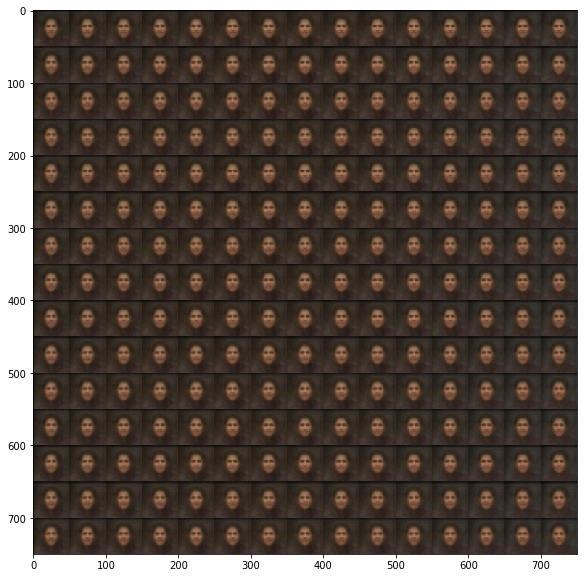

In [22]:
# display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 50
figure = np.zeros((digit_size * n, digit_size * n, 3))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-2, 2, n)
grid_y = np.linspace(-2, 2, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]+[0]*(latent_dim-2)]) * epsilon_std
        x_decoded = sess.run(net.core_model.output_z, feed_dict={net.ph.z:z_sample})
        digit = x_decoded[0].reshape(digit_size, digit_size, 3)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)

plt.show()

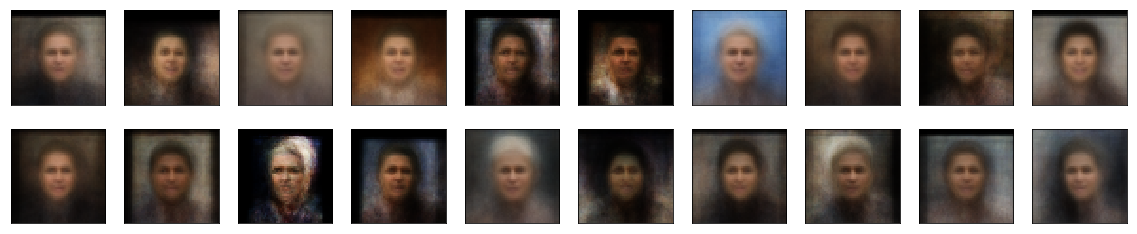

In [23]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(sess.run(net.core_model.output_z, feed_dict={net.ph.z:np.random.normal(size=(1, latent_dim), loc=0, scale=1)}).reshape(50, 50, 3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(sess.run(net.core_model.output_z, feed_dict={net.ph.z:np.random.normal(size=(1, latent_dim), loc=0, scale=1)}).reshape(50, 50, 3))
    # plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()